# Calculate mangrove blue carbon
Based on https://code.earthengine.google.com/b1e2d678541dc3e9ff46eaf85df175c9

The export grid used has been calculated as the max allowed pixel size for the GEE export:
sqrt()

This code creates a raster imageCollection representing the total carbon
(in CO2e units) stock of global mangrove ecotypes per hectare (t CO2e / ha).  

Input data:  
* soc: mangrove soil organic carbon t OC / m2
* agb: above ground biomass t / m2

Conversions:
* soc: t OC / m2 -> t CO2e / m2  
* agb: t / m2 -> t CO2e / m2
* bgb: agb t / m2 -> bgb  t / m2 -> t CO2e / m2

Factors:
* Above to Below Ground Biomass: 0.49 (Simard et al. 2019)
* Biomass to Carbon: 0.451 (Simard et al. 2019)
* Organic Carbon to CO2e: 11/3 = 3.66 

In [190]:
import os
import ee
import geemap
import geopandas as gpd
from geopandas.tools import sjoin
import math
from shapely.geometry import Polygon
from itertools import product
from pyproj import Transformer
import shapely.speedups
shapely.speedups.enable()

In [2]:
# Trigger the authentication flow.
#ee.ServiceAccountCredentials(EE_ACCOUNT, EE_PRIVATE_KEY_FILE)
ee.Authenticate()
# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


### Data Assets

### Create the Blue carbon asset

In [38]:
os.getcwd()

'/home/jovyan/work/notebooks/Lab/data_processing/GEE'

In [161]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3410")
xmin, ymin = transformer.transform(-90, -180)
print(xmin, ymin)

-17334193.943686873 -7356860.401736962


In [51]:
# TODO: Create a function to create a grid for data download that takes into account:
# the max nº pixels per asset exported from GEE to GCS asset (maxPixels)
# Create a buffered polygon 2km for the coastline
# Clip the buffered polygon with the mangrove bbox extent
# Filter the grid by those that intersect the clipped buffered geometry

In [162]:
def square(width, heigh, xmin, ymin):
    xmax = xmin + width
    ymax = ymin + heigh
    return Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])


def sq_grid(extent: list, size: int) -> gpd.GeoDataFrame:

    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3410")
    xmin_deg, ymin_deg, xmax_deg, ymax_deg =  extent
    xmin, ymin = transformer.transform(ymin_deg, xmin_deg)
    xmax, ymax = transformer.transform(ymax_deg, xmax_deg)
    
    width = size
    height = size
    
    print((ymax-ymin))
   
    rows = int(math.ceil((ymax-ymin) / height))
    cols = int(math.ceil((xmax-xmin) / width))
    polygons = []

    for i, j  in product(range(cols), range(rows)):
        x = xmin + i * width
        y = ymin + j * height
        polygons.append(square(width, height, x, y))
       

    return gpd.GeoDataFrame({'geometry':polygons}, crs = 'EPSG:3410').to_crs("EPSG:4326") 

In [163]:
n_pixels = math.floor(math.sqrt(10e12))

In [166]:
grid = sq_grid([-180,-50, 180, 50], n_pixels)
coast_line = gpd.read_file('/home/jovyan/work/datasets/raw/coastlines-mangroves-v1.shp')

11271364.059105303


<AxesSubplot:>

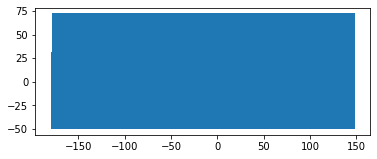

In [200]:
pip_mask = grid.intersects(coast_line.loc[0, 'geometry'])
sub = grid.loc[pip_mask]
sub.reset_index(drop=True, inplace=True)
sub.plot()

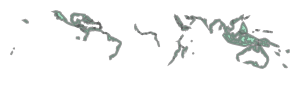

In [179]:
coast_line.geometry.unary_union

In [189]:
grid.filter(grid.geometry.intersects(coast_line.geometry.unary_union)).plot

/opt/conda/lib/python3.8/site-packages/geopandas/array.py:918: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
/opt/conda/lib/python3.8/site-packages/geopandas/array.py:919: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
/opt/conda/lib/python3.8/site-packages/geopandas/array.py:920: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
/opt/conda/lib/python3.8/site-packages/geopandas/array.py:921: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

In [185]:
pipw = grid.within(coast_line.loc[0, 'geometry'])
ec_gdf = grid.loc[pipw]
ec_gdf.plot()

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

ValueError: cannot convert float NaN to integer

<Figure size 432x288 with 1 Axes>

<AxesSubplot:>

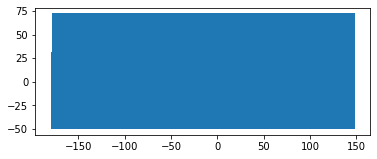

In [170]:
pointInPolys = sjoin(grid, coast_line, how='inner')
pointInPolys.plot()

In [43]:
export_tiles = gpd.read_file('/home/jovyan/work/datasets/raw/grid-download.shp')

In [45]:
fc = geemap.geopandas_to_ee(export_tiles)

In [6]:
# SET CONSTANTS
# factor to convert above-ground biomass to below-ground biomass (Simard et al. 2019)
agb_to_bgb = ee.Number(0.49)
# factor to convert above-ground biomass to organic carbon (Simard et al. 2019)
biomass_to_OC = ee.Number(0.451)
# factor to convert organic carbon to CO2 equivilent
OC_to_CO2e = ee.Number(11).divide(3)

maxPixels = 1e12
## Assets selection
#agb: above-ground biomass density
agb = ee.Image(ee.ImageCollection(
    "projects/global-mangrove-watch/mangrove-properties/mangrove_aboveground_biomass_1996-2016").first())
# oc : soil organic carbon
soc = ee.Image("projects/global-mangrove-watch/mangrove-properties/mangroves_SOC30m_0_100cm")

In [63]:
maxPixels = 1e12
nms = soc.projection().nominalScale().getInfo()
math.sqrt(maxPixels) * nms 

27829872.698318392

In [7]:
agb.projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:4326',
 'transform': [0.00027777777777779285,
  0,
  -180.0001388888889,
  0,
  -0.00027777777777779285,
  35.00013888888889]}

In [8]:
soc.projection().getInfo()

{'type': 'Projection',
 'crs': 'EPSG:4326',
 'transform': [0.00025, 0, -119.00025000000001, 0, -0.00025, 33.9995]}

In [10]:
def organic_c_to_co2(oc: ee.Image) -> ee.Image:
    return oc.multiply(OC_to_CO2e)

def biomass_to_co2(biomass: ee.Image) -> ee.Image:
    return organic_c_to_co2(biomass.multiply(biomass_to_OC))

def above_to_below(agb: ee.Image) -> ee.Image:
    return agb.multiply(agb_to_bgb)


In [11]:
def calculate_blue_carbon(soc: ee.Image, abg: ee.Image):
    """
    Calculate the blue carbon from soil organic carbon and the above ground biomass.
    """
    bgb = above_to_below(abg)
    soc_co2 = (organic_c_to_co2(soc.updateMask(soc.gt(0)))).rename('soc_co2e')
    abg_co2 = (biomass_to_co2(abg.updateMask(abg.gt(0)))).rename('agb_co2e')
    bgb_co2 = (biomass_to_co2(bgb)).rename('bgb_co2e')
    
    # Return the image with the blue carbon.
    return ee.Image(soc_co2.add(abg_co2).add(bgb_co2)).rename('total_co2e')

In [ ]:
def export_data(asset, gcbucket, geometry_collection):
    nms = asset.projection().nominalScale().getInfo()
    
    taskList = []
    
    for geometry in geometry_collection:
        task = ee.batch.Export.image.toCloudStorage(
           image = asset,
           bucket =gcbucket,
           fileNamePrefix = f'ee_export_tiffs/test_total_organic_carbon',
           description = 'test_total_organic_carbon',
           scale = nms,
           region = ee.Feature(geometry).geometry(),
           maxPixels=1e12)
        task.start()
        taskList.append(task.id)
    
    return taskList

In [12]:
blue_carbon = calculate_blue_carbon(soc, agb)

In [35]:
blue_carbon.projection().nominalScale().getInfo()

27.829872698318393

In [201]:
data = blue_carbon.reduceRegions(
    collection=fc,
    reducer=ee.Reducer.sum()
).getInfo()

KeyboardInterrupt: 

In [13]:
print(blue_carbon.getDownloadUrl({
    'scale': nms,
    'crs': 'EPSG:4326',
    'region': '[[39.184112548828125,-6.525458832948283],[39.494476318359375,-6.525458832948283],[39.494476318359375,-6.255236941610093],[39.184112548828125,-6.255236941610093],[39.184112548828125,-6.525458832948283]]'
}))

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/f0870b6df88827e4841686043ef5e5bd-0f9cdc2202b333eecb6274697390f634:getPixels


In [46]:
Map = geemap.Map(center=(-5, 39), zoom=12, basemap='HYBRID')
vis_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}
Map.addLayer(blue_carbon, vis_params, 'SRTM DEM', True, 0.5)
Map.addLayer(fc, {}, "geopandas to ee")
Map

Map(center=[-5, 39], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Tog…

In [54]:
fc.filterMetadata('id', 'equals', 5365).getInfo()

{'type': 'FeatureCollection',
 'columns': {'bottom': 'Float',
  'id': 'Integer',
  'left': 'Float',
  'right': 'Float',
  'system:index': 'String',
  'top': 'Float'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[137.5269444084186, -10.764269946279322],
      [140.22189026077717, -10.764269946279322],
      [140.22189026077717, -8.106033547276628],
      [137.5269444084186, -8.106033547276628],
      [137.5269444084186, -10.764269946279322]]]},
   'id': '571',
   'properties': {'bottom': -1205384.9094000002,
    'id': 5365,
    'left': 15309429.4219,
    'right': 15609429.4219,
    'top': -905384.9094000002}}]}

In [55]:
task = ee.batch.Export.image.toCloudStorage(
           image = blue_carbon,
           bucket ='mangrove_atlas',
           fileNamePrefix = f'ee_export_tiffs/test_total_organic_carbon',
           description = 'test_total_organic_carbon',
           scale = nms,
           region = fc.filterMetadata('id', 'equals', 5365).geometry(),
           maxPixels=1e12)
task.start()

In [56]:
task.id

'ZNMW6W6YQ3LKW2M4GYUYB63U'

In [59]:
task.status()

{'state': 'RUNNING',
 'description': 'test_total_organic_carbon',
 'creation_timestamp_ms': 1658310882965,
 'update_timestamp_ms': 1658310894156,
 'start_timestamp_ms': 1658310891393,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'id': 'ZNMW6W6YQ3LKW2M4GYUYB63U',
 'name': 'projects/earthengine-legacy/operations/ZNMW6W6YQ3LKW2M4GYUYB63U'}

In [5]:
coll = ee.ImageCollection("projects/global-mangrove-watch/mangrove-properties/mangrove_total_co2e_1996--2016").select('total_co2e')
listOfImages = coll.toList(coll.size());

In [9]:
print(listOfImages.get(0).getInfo())

{'type': 'Image', 'bands': [{'id': 'total_co2e', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1440000, 268000], 'crs': 'EPSG:4326', 'crs_transform': [0.00025, 0, -180, 0, -0.00025, 33]}], 'version': 1593108753126050.0, 'id': 'projects/global-mangrove-watch/mangrove-properties/mangrove_total_co2e_1996--2016/mangrove_total_carbon_1996', 'properties': {'system:time_start': 820454400000, 'sldStyle': '<RasterSymbolizer><ColorMap type="ramp" extended="false" ><ColorMapEntry color="#5c4a3d" quantity="400" label="400"/><ColorMapEntry color="#933a06" quantity="800" label="800" /><ColorMapEntry color="#b84e17" quantity="1200" label="1200" /><ColorMapEntry color="#e68518" quantity="1600" label="1600" /><ColorMapEntry color="#eeb66b" quantity="2000" label="2000" /></ColorMap></RasterSymbolizer>', 'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}, 'system:asset_size': 3107628521, 'system:index': 'man